This is a list of all the libraries that are used in this analysis

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, silhouette_score
import numpy as np
from scipy.stats import pearsonr, percentileofscore
from matplotlib import pyplot

Right now the data is imported from two excels which have advanced stats and player totals for the season. This will probably chance in the furture to getting data from basketball-reference.com. I also need to merge the two dataframes and remove duplicates. The duplicates occur when a player is traded from one team to another in the middle of the season.

In [3]:
df_advanced = pd.read_excel('Advanced Stats.xlsx')
df_total_stats = pd.read_excel('Total Stats.xlsx')
df = df_advanced.merge(df_total_stats, on = ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'Rk'])
df.drop_duplicates(['Player'], keep='first',inplace=True)

I am going to make a copy of the original df since I will remove some columns (Player name, position, team, age etc.) as they aren't important for analysis. I will need the player name later on to see which players cluster together. There are also some columns with NAs which I will drop as well as players with total time played less than 1000  minutes.

In [4]:
df.dropna(axis=1,inplace=True)
idx = df.index[df['MP']<1000]
df.drop(idx,inplace=True)
idx_gp = df.index[df['G']<50]
df.drop(idx_gp,inplace=True)
df_copy = df.copy(deep=True)
df.drop(['Pos', 'Rk', 'Tm', 'Player'],axis=1,inplace=True)

I am going to split the data into a train/test set. Since I want to keep a track of the training data in the original data frame, I will create a dummy array and split it then use those indices to split the dataframe.

In [5]:
indices = np.arange(0,np.shape(df)[0])
indices_train, indices_test  = train_test_split(indices, test_size=0.0)
train_df = df.iloc[indices_train,:]
test_df = df.iloc[indices_test,:]
train_df_copy = df_copy.iloc[indices_train,:]
test_df_copy = df_copy.iloc[indices_test,:]

Since there are 37 features, Ill use PCA for dimensionality reduction. But first, the data needs to be standardized

In [6]:
scaler = preprocessing.StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df),columns=df.columns)

C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For PCA we need to determine the number of compopnents. Here, I used the explained variance ratio to determine the number of components

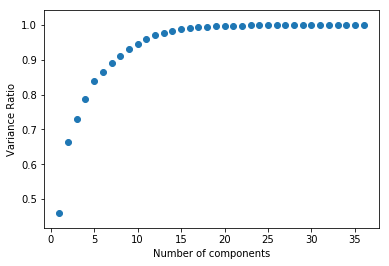

In [7]:
evr = []
for components in range(1, np.shape(train_df_scaled)[1]):
    pca = PCA(n_components=components)
    pca.fit(train_df_scaled)
    if components == 1:
        evr.append(pca.explained_variance_ratio_[-1])
    else:
        evr.append(evr[-1]+pca.explained_variance_ratio_[-1])

plt.scatter(np.arange(1,np.shape(df)[1]),evr)
plt.xlabel('Number of components')
plt.ylabel('Variance Ratio')
plt.show()
#     kmeans = KMeans(n_clusters=n_cluster,random_state=1).fit(X_train)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(X_train, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

Seems like 16 is a good number of components to use. Now we can check the correlation between the principal components and the original features.

Next, we need to determine the number of clusters. We can do this by using the Silhouette Measure and Elbow Method.

For n_clusters=2, The Silhouette Coefficient is 0.3284749328899726
For n_clusters=3, The Silhouette Coefficient is 0.2927403407481235
For n_clusters=4, The Silhouette Coefficient is 0.20438639955694105
For n_clusters=5, The Silhouette Coefficient is 0.18866800903948555
For n_clusters=6, The Silhouette Coefficient is 0.17072906332680393
For n_clusters=7, The Silhouette Coefficient is 0.1311397189125471
For n_clusters=8, The Silhouette Coefficient is 0.13146719773804572
For n_clusters=9, The Silhouette Coefficient is 0.1167295491835928
For n_clusters=10, The Silhouette Coefficient is 0.11365850457503728
For n_clusters=11, The Silhouette Coefficient is 0.11578821578567142
For n_clusters=12, The Silhouette Coefficient is 0.11771261678566491
For n_clusters=13, The Silhouette Coefficient is 0.1149820978975147
For n_clusters=14, The Silhouette Coefficient is 0.11470114798856756
For n_clusters=15, The Silhouette Coefficient is 0.11748134228482099
For n_clusters=16, The Silhouette Coefficient i

No handles with labels found to put in legend.


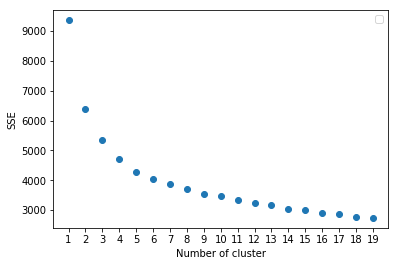

In [8]:
pca = PCA(n_components=15)
reduced_features = pca.fit_transform(train_df_scaled)

for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(reduced_features)
    label = kmeans.labels_
    sil_coeff = silhouette_score(reduced_features, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(reduced_features)
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(list(sse.keys()))
plt.legend()
plt.show()

Its a bit hard to interprety the silhouette measure but using the elbow method shows that 11 clusters is a good choice. After clustering I also save the name of each players in each cluster for later reference.

In [47]:
kmeans = KMeans(n_clusters=11).fit(reduced_features)
labels = kmeans.labels_ 
train_df_copy['labels'] = labels
names = {}
unique_labels = list(set(labels))
for i in range(len(unique_labels)):
    names[i] = train_df_copy[train_df_copy['labels']==unique_labels[i]]['Player']

C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Lets try some visualization. Since the reduced features are hard to interpret I inversed the cluster centers to the original feature values (by unnormalizing). I also calculated the percentile for each feature of each cluster and used a barplot to visualize the features of each cluster

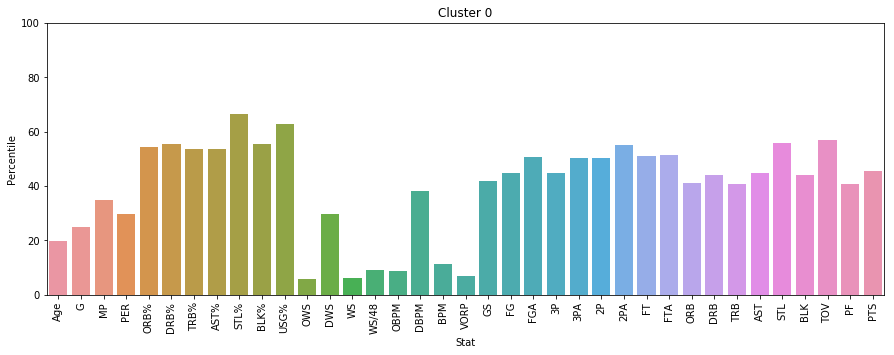

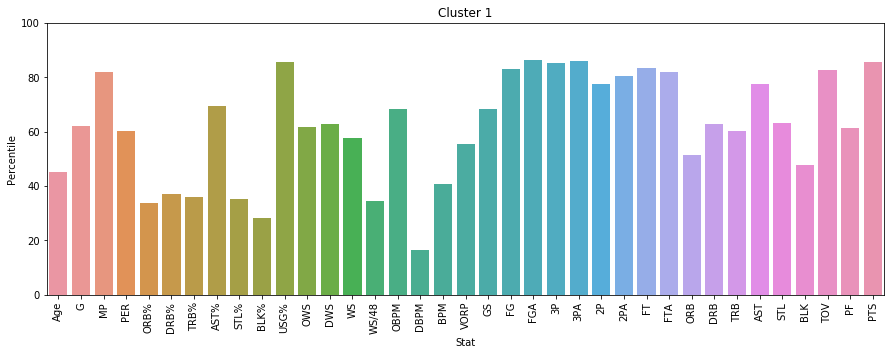

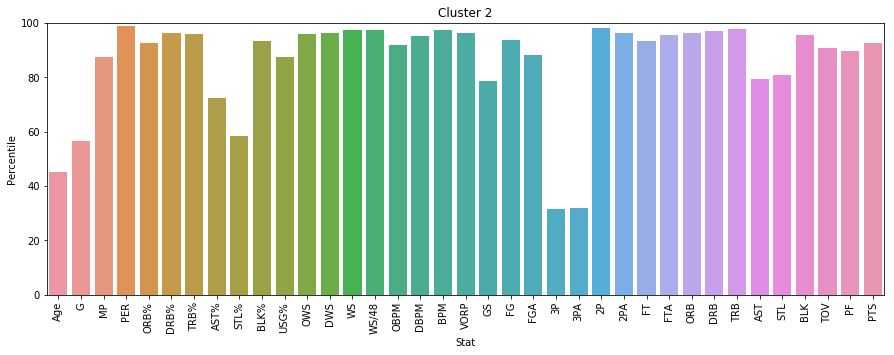

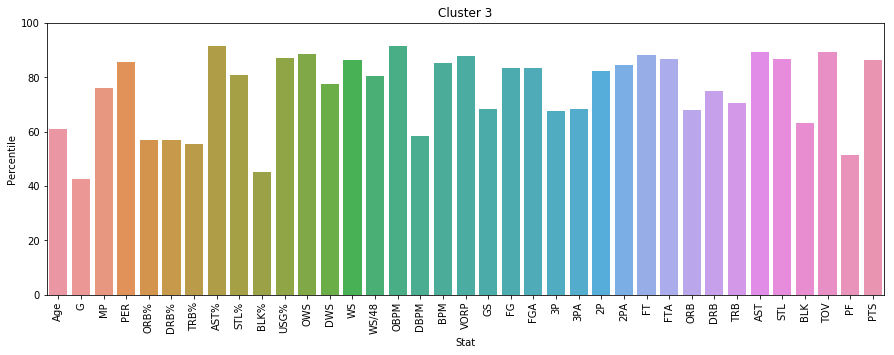

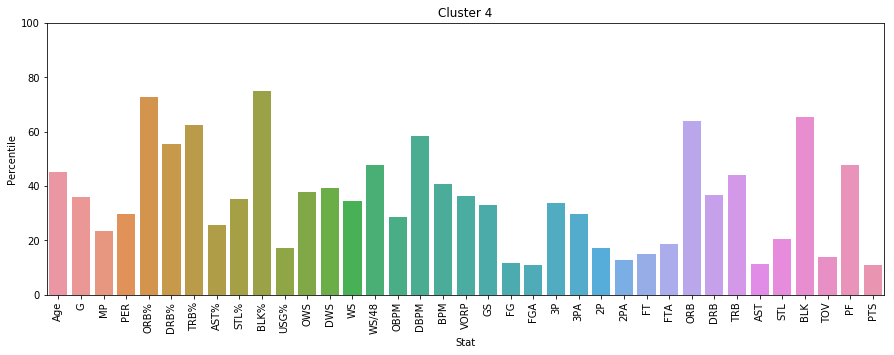

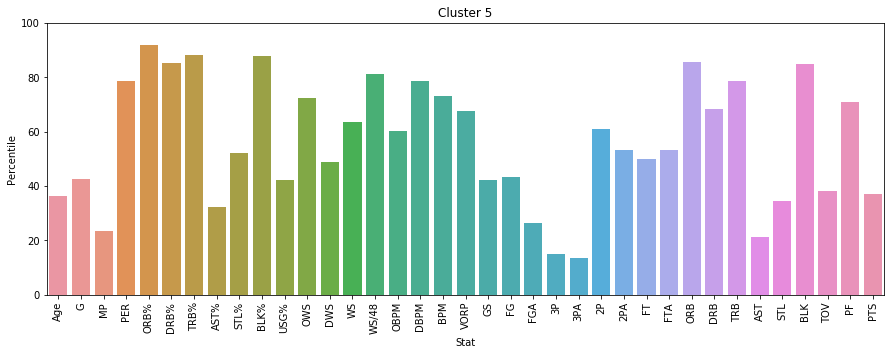

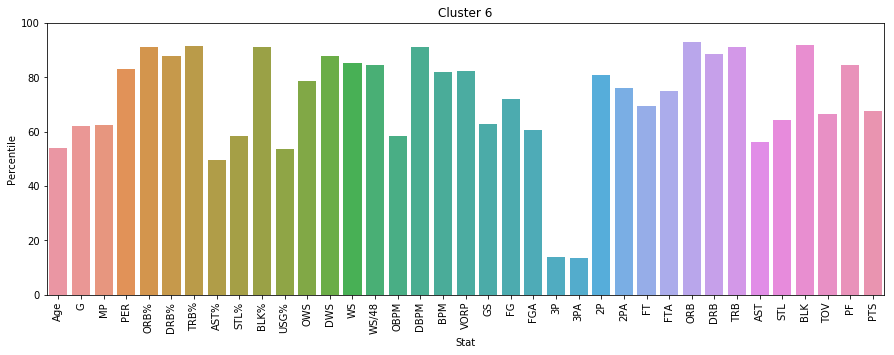

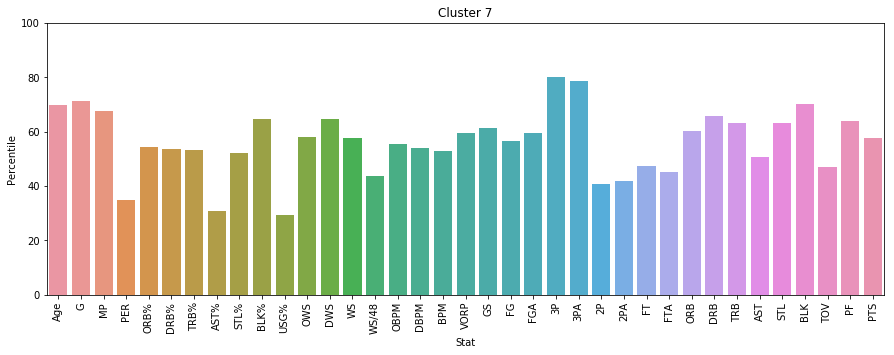

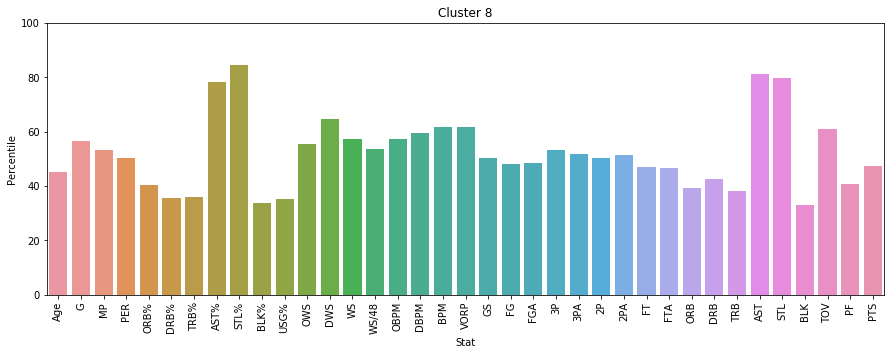

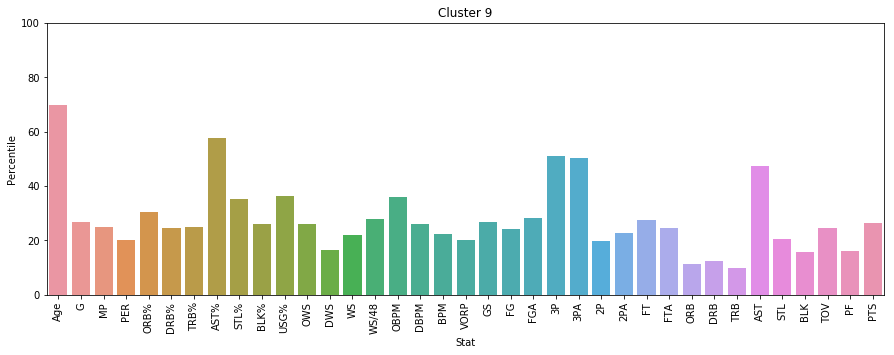

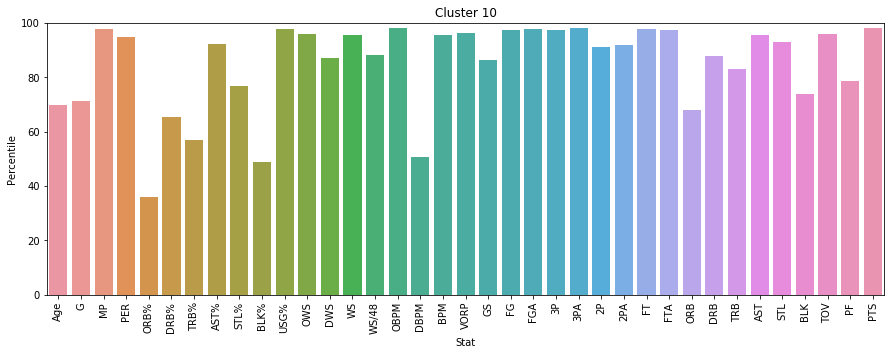

In [50]:
original_centers = {}
for i in range(len(kmeans.cluster_centers_)):
    original_centers[i] = scaler.inverse_transform(np.dot(kmeans.cluster_centers_[i], pca.components_))

percentiles = {}
for i in range(len(original_centers)):
    percentiles[i] = []
    for j in range(len(original_centers[0])):
        percentiles[i].append(percentileofscore(train_df.iloc[:,j],original_centers[i][j]))

for i in range(len(percentiles)):
    fig, ax = pyplot.subplots(figsize=(15,5))
    fig = sns.barplot(train_df.columns.tolist(),percentiles[i])
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    fig.set(ylim=(0, 100))
    ax.set_title('Cluster '+ str(i))
    ax.set_xlabel('Stat')
    ax.set_ylabel('Percentile')


In [45]:
display(names[1])
display(names[5])
display(names[9])

19     Giannis Antetokounmpo
353             Nikola Jokic
661           Nikola Vucevic
7          LaMarcus Aldridge
161            Anthony Davis
244              Rudy Gobert
200              Joel Embiid
598              Ben Simmons
675        Russell Westbrook
188           Andre Drummond
647       Karl-Anthony Towns
Name: Player, dtype: object

191      Kevin Durant
261     Blake Griffin
401    Damian Lillard
159     Stephen Curry
267      James Harden
665      Kemba Walker
47       Bradley Beal
240       Paul George
Name: Player, dtype: object

388         Zach LaVine
596       Pascal Siakam
554       Julius Randle
684        Lou Williams
230    Danilo Gallinari
332        LeBron James
699          Trae Young
321        Kyrie Irving
457     Khris Middleton
68         Devin Booker
174       DeMar DeRozan
469    Donovan Mitchell
573    D'Angelo Russell
61         Eric Bledsoe
298        Jrue Holiday
102        Jimmy Butler
143         Mike Conley
273       Tobias Harris
397       Kawhi Leonard
181         Luka Doncic
222        De'Aaron Fox
Name: Player, dtype: object